# EUROS 2024

When I was first learning the basics of soccer, my coach pulled me and the rest of the defenders aside and said, "Whenever we score, I want you to be on high alert for the next five minutes. The average time for a team to respond to a goal is five minutes." This was perhaps the first statistical measure I was conscious of having meaning for me.

I want to find the average time it takes for a goal to be scored...after a goal has already been scored!


I created a data set from match results on ESPN's Euro 2024 Bracket (https://www.espn.com/soccer/story/_/page/uefaeuro/euro-2024-bracket-fixtures-schedule-finals).


In [283]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/Users/mattnelson/Desktop/GitHub/Example-Work/Euros/Euros2024 - Sheet1.csv'  
df = pd.read_csv(file_path)


### Goals by half

I want to see what the splits are for goals for first half, second half, and extra time

In [151]:
df

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes
0,7/14/2024,45,Spain,1,2,47,0.0,NaN
1,7/14/2024,45,England,2,2,73,26.0,NaN
2,7/14/2024,45,Spain,3,2,86,13.0,NaN
3,7/10/2024,44,Netherlands,1,1,7,0.0,NaN
4,7/10/2024,44,England,2,1,18,11.0,Penalty
...,...,...,...,...,...,...,...,...
112,6/14/2024,1,Germany,2,1,19,9.0,NaN
113,6/14/2024,1,Germany,3,1,46,27.0,"Penalty, Stoppage_HT"
114,6/14/2024,1,Germany,4,2,68,22.0,NaN
115,6/14/2024,1,Scotland,5,2,87,19.0,Own_Goal


In [155]:
halves = df.groupby('Half').agg('count')

In [156]:
halves

,Date,Match_ID,Team,Aggregate,Minute,Duration,Notes
Half,,,,,,,
1,51,51,51,51,51,51,9
2,64,64,64,64,64,64,22
3,2,2,2,2,2,2,0


In [157]:
halves.index

Int64Index([1, 2, 3], dtype='int64', name='Half')

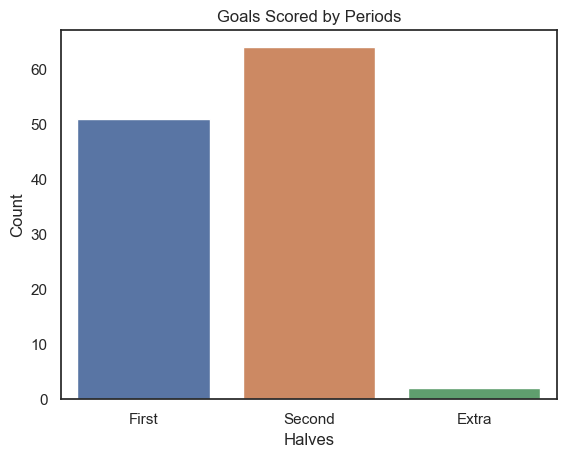

In [162]:
sns.set_theme(style="white")
ax=sns.barplot(x=['First', 'Second', 'Extra'], y=halves.Team)
ax.set_title('Goals Scored by Periods')
ax.set_ylabel('Count')
ax.set_xlabel('Halves');

In [131]:
t=df[['Team','Half']].groupby(['Team','Half']).value_counts().reset_index()

In [136]:
t = t.rename(columns={0:'Count'})

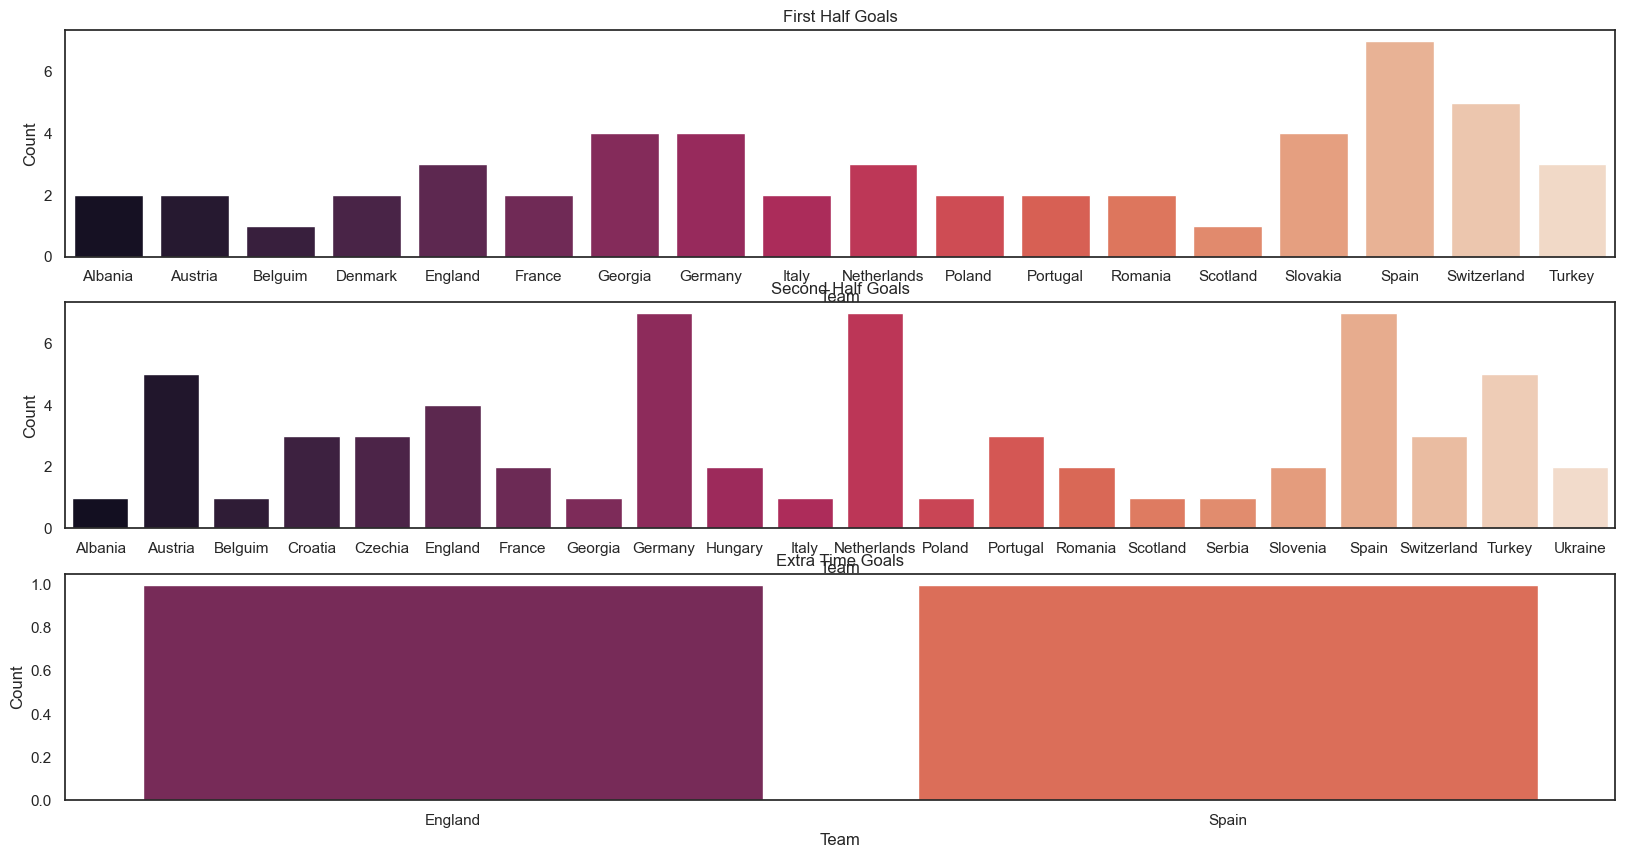

In [166]:
first = t[t['Half']==1]
second = t[t['Half']==2]
extra = t[t['Half']==3]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

sns.barplot(x=first['Team'], y=first['Count'], palette="rocket", ax=ax1)
ax1.set_title('First Half Goals')
ax2.set_title('Second Half Goals')
ax3.set_title('Extra Time Goals')
sns.barplot(x=second['Team'], y=second['Count'], palette="rocket", ax=ax2)
sns.barplot(x=extra['Team'], y=extra['Count'], palette="rocket", ax=ax3);


## Average time after a goal for another goal

I want to find the time it takes a team to score a goal AFTER a goal has been scored. I'll be able to use this info for the average.

In [286]:
for i in range(len(df)):
    if df.loc[i,'Aggregate']==1:
        df.loc[i,'Duration']=0
    else:
        df.loc[i, 'Duration'] = df.loc[i, 'Minute']-df.loc[i-1, 'Minute']

In [44]:
print('The average duration between goals is ', df['Duration'].mean(), ' minutes')

The average duration between goals is  15.025641025641026  minutes


Let's do some graphing! 

In [71]:
#Get all the teams (which are in order of how well they did)
teams = df.Team.unique()

#Create a list of the average duration of time after a goal to score
avg_dur = []
for team in teams:
    avg_dur.append(df[df['Team']==team]['Duration'].mean())

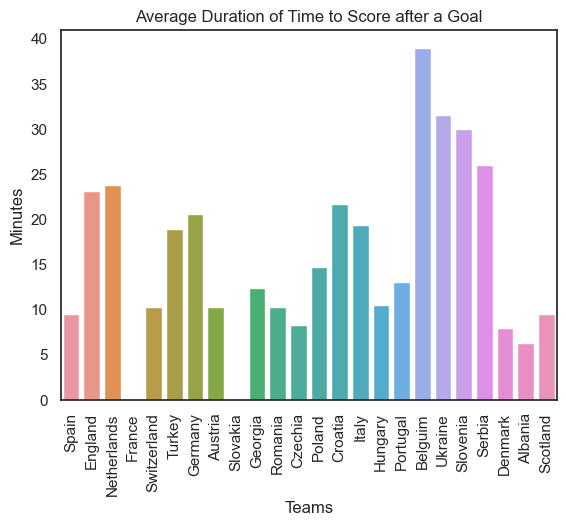

In [89]:
#Plot a bargraph

sns.set_theme(style="white")
ax=sns.barplot(x=teams, y=avg_dur)
ax.set_title('Average Duration of Time to Score after a Goal')
ax.set_ylabel('Minutes')
ax.set_xlabel('Teams')
plt.xticks(rotation=90);

I also want to see the average minute teams scored as well as the total amount of goals scored for each team.

In [74]:
goals_per_team = df['Team'].value_counts()

In [75]:
goals_per_team

Spain          15
Germany        11
Netherlands    10
Switzerland     8
Turkey          8
England         8
Austria         7
Georgia         5
Portugal        5
France          4
Slovakia        4
Romania         4
Italy           3
Albania         3
Poland          3
Croatia         3
Czechia         3
Hungary         2
Belguim         2
Ukraine         2
Slovenia        2
Denmark         2
Scotland        2
Serbia          1
Name: Team, dtype: int64

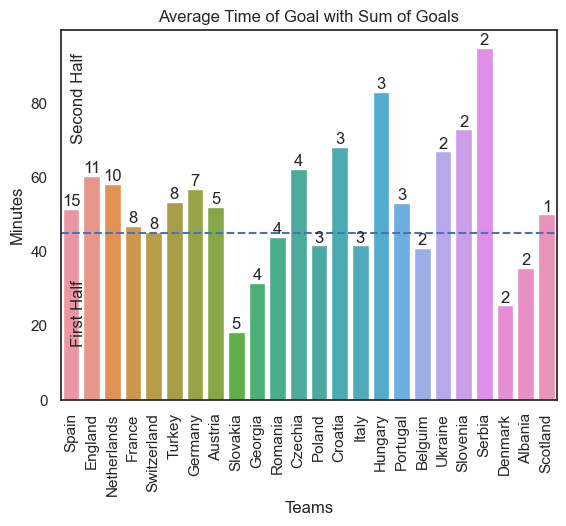

In [90]:
avg_min = []
for team in teams:
    avg_min.append(df[df['Team']==team]['Minute'].mean())

ax=sns.barplot(x=teams, y=avg_min)
ax.set_title('Average Time of Goal with Sum of Goals')
ax.set_ylabel('Minutes')
ax.set_xlabel('Teams')
ax.axhline(y = 45, linestyle = "dashed")
plt.xticks(rotation=90)
ax.text(0, 15, "First Half", rotation=90)
ax.text(0, 70, "Second Half", rotation=90)
ax.bar_label(ax.containers[0], labels=goals_per_team);

Of the teams with an average duration of 0, I want to explore France more. My guess is that they scored first every time. 

I will make a subset of just France and see their Aggregate data is all 1s.

In [69]:
france = df[df['Team']=='France'].copy()
france

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes,Durcation
6,7/9/2024,43,France,1,1,9,0.0,NaN,NaN
23,7/1/2024,37,France,1,2,85,0.0,NaN,NaN
43,6/25/2024,29,France,1,2,56,0.0,Penalty,NaN
94,6/17/2024,8,France,1,1,38,0.0,Own_Goal,NaN


In [68]:
slovakia = df[df['Team']=='Slovakia'].copy()
slovakia

,Date,Match_ID,Team,Aggregate,Half,Minute,Duration,Notes,Durcation
24,6/30/2024,36,Slovakia,1,1,25,0.0,NaN,NaN
36,6/26/2024,32,Slovakia,1,1,24,0.0,NaN,NaN
63,6/21/2024,20,Slovakia,1,1,17,0.0,NaN,NaN
93,6/17/2024,9,Slovakia,1,1,7,0.0,NaN,NaN


In [195]:
goal_num = df['Aggregate'].unique()

In [231]:
for goal in goal_num:
    print(goal)

1
2
3
4
5
6


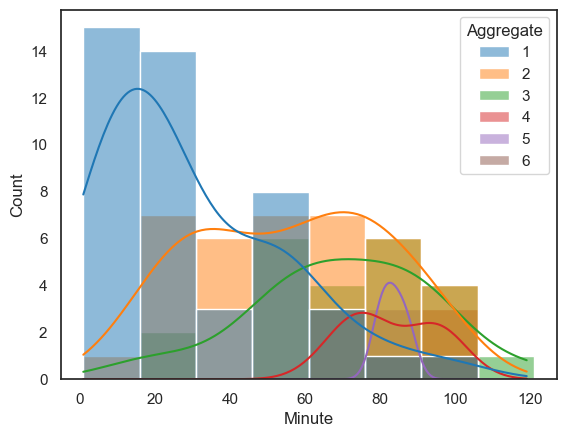

In [194]:
sns.histplot(data=df, x='Minute', kde=True, hue='Aggregate', binwidth=15, palette='tab10')
ax.set_title(' Time of Goals for Each Goal Number');

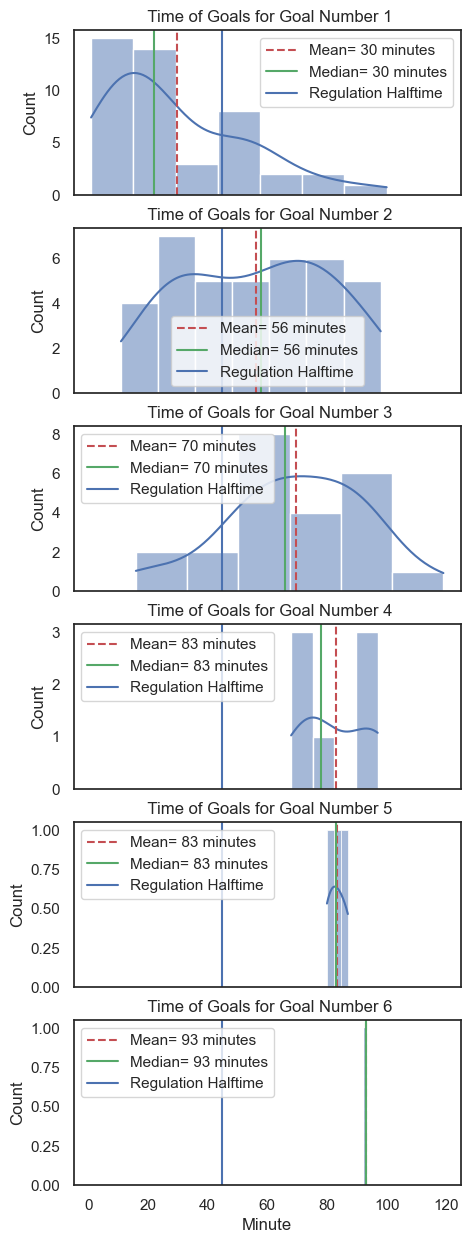

In [394]:
fig, ax = plt.subplots(6, 1, figsize = (5, 15), sharex=True)
for goal in goal_num:
    plt.sca(ax[goal-1])
    sns.histplot(data=df[df['Aggregate']==goal], x=df[df['Aggregate']==goal]['Minute'], kde=True)
    ax[goal-1].set_title(' Time of Goals for Goal Number ' + str(goal))
    ax[goal-1].axvline(df[df['Aggregate']==goal]['Minute'].mean(), color='r', linestyle='--', 
                       label='Mean= {} minutes'.format(round(df[df['Aggregate']==goal]['Minute'].mean())))
    ax[goal-1].axvline(df[df['Aggregate']==goal]['Minute'].median(), color='g', linestyle='-', 
                       label='Median= {} minutes'.format(round(df[df['Aggregate']==goal]['Minute'].mean())))
    ax[goal-1].axvline(x=45, label='Regulation Halftime', color='b', linestyle='-')
    ax[goal-1].legend()
    ;

In [272]:
for goal in goal_num:
    print('There were ' + str(df[df['Aggregate']==goal]['Match_ID'].count()) + 
          ' goals for goal number ' + str(goal))

There were 45 goals for goal number 1
There were 38 goals for goal number 2
There were 23 goals for goal number 3
There were 7 goals for goal number 4
There were 3 goals for goal number 5
There were 1 goals for goal number 6


## Let's create a predictor! 

I'm going to use XGBoost Regressor to try and make a prediction for each goal. I think this is a good place to pause and think about engineering some other variables to make the model more robust. I'm also interested in using Bayesian statistics to create a model after listening to a podcast episdoe on Super Data Podcast.

In [308]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

In [277]:
df.dtypes

Date          object
Match_ID       int64
Team          object
Aggregate      int64
Half           int64
Minute         int64
Duration     float64
Notes         object
dtype: object

I also want to get rid of the first three rows because I want to test on the Spain vs England game

In [295]:
df.Duration.value_counts()

0.0     45
13.0     4
12.0     4
7.0      4
21.0     3
5.0      3
15.0     3
26.0     3
10.0     3
27.0     2
33.0     2
19.0     2
16.0     2
23.0     2
28.0     2
24.0     2
9.0      2
63.0     2
6.0      2
4.0      2
1.0      1
37.0     1
3.0      1
11.0     1
60.0     1
54.0     1
32.0     1
72.0     1
45.0     1
2.0      1
36.0     1
78.0     1
70.0     1
64.0     1
43.0     1
35.0     1
41.0     1
55.0     1
38.0     1
30.0     1
8.0      1
58.0     1
22.0     1
Name: Duration, dtype: int64

In [387]:
X = df.drop(columns='Minute', axis=1)
y = df['Minute'].reset_index()

In [298]:
X = X[3:]

In [338]:
y= y[3:]

In [300]:
X

,Date,Match_ID,Team,Aggregate,Half,Duration,Notes
3,7/10/2024,44,Netherlands,1,1,0.0,NaN
4,7/10/2024,44,England,2,1,11.0,Penalty
5,7/10/2024,44,England,3,2,72.0,NaN
6,7/9/2024,43,France,1,1,0.0,NaN
7,7/9/2024,43,Spain,2,1,12.0,NaN
...,...,...,...,...,...,...,...
112,6/14/2024,1,Germany,2,1,9.0,NaN
113,6/14/2024,1,Germany,3,1,27.0,"Penalty, Stoppage_HT"
114,6/14/2024,1,Germany,4,2,22.0,NaN
115,6/14/2024,1,Scotland,5,2,19.0,Own_Goal


In [340]:
y.drop(columns='index', inplace=True)

In [302]:
X.drop(columns = ['Date', 'Match_ID'], axis=1, inplace=True)

In [388]:
X=pd.get_dummies(X, columns=['Team', 'Aggregate','Half', 'Notes'])

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4242)

ValueError: Found input variables with inconsistent numbers of samples: [117, 114]

In [319]:
eu = xgb.XGBRegressor()

In [321]:
eu.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [322]:
y_pred=eu.predict(X_test)

In [324]:
predictions = [round(value) for value in y_pred]

In [344]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE: %f' %(rmse))
               

RMSE: 11.032866


In [347]:
#Going to try and make a Linear Based Learner
DM_train = xgb.DMatrix(data= X_train, label=y_train)
DM_test =  xgb.DMatrix(data= X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 14.025865


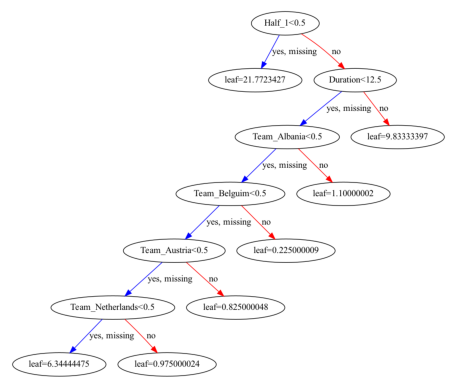

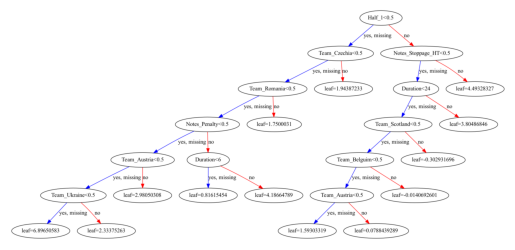

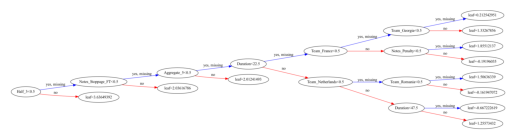

In [354]:
# Plot the first tree
xgb.plot_tree(eu, num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(eu, num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(eu, num_trees=9, rankdir='LR')
plt.show()

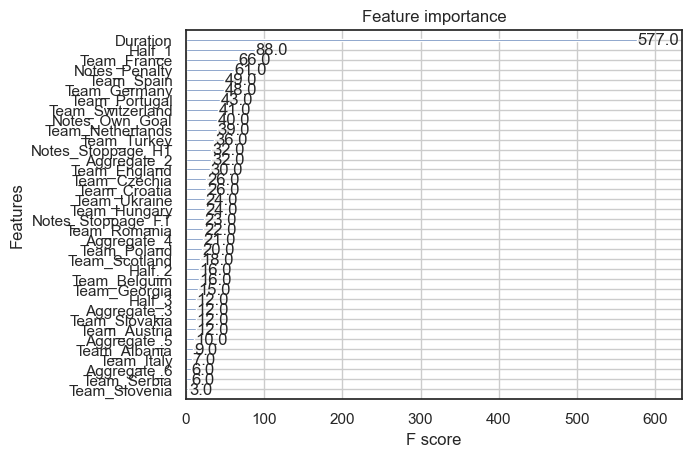

In [356]:
xgb.plot_importance(eu)
plt.show()

In [370]:
len(y_test)

29

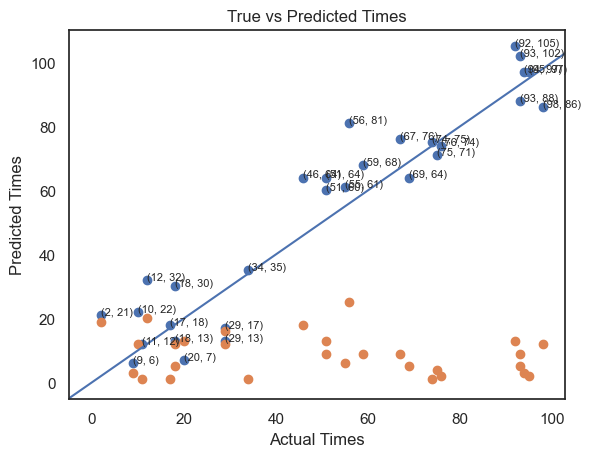

In [375]:
plt.scatter(x=y_test, y=predictions)
plt.scatter(x=y_test, y=abs(y_test-predictions))
plt.xlabel('Actual Times')
plt.ylabel('Predicted Times')
plt.title('True vs Predicted Times')
plt.axline((0, 0), slope=1)

for x,y in zip(y_test, predictions):                                     
     plt.text(x, y, f"({x}, {y})", fontsize=8)
plt.show()

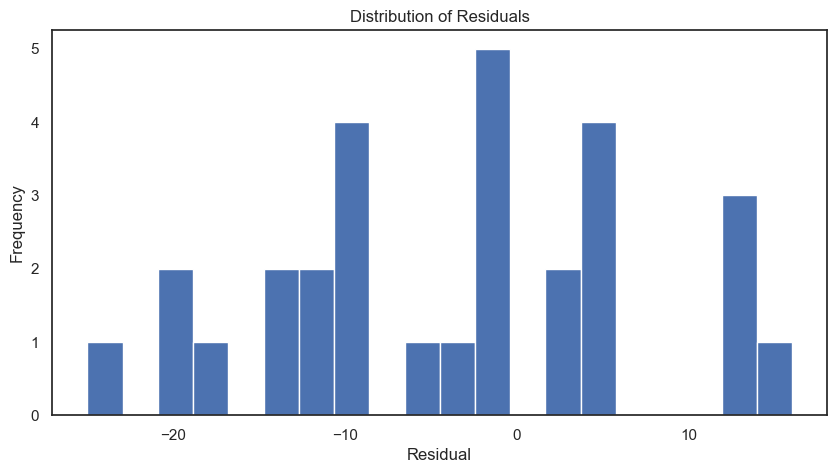

In [368]:
residuals=y_test-predictions
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

,Date,Match_ID,Team,Aggregate,Half,Duration,Notes
0,7/14/2024,45,Spain,1,2,0.0,NaN
1,7/14/2024,45,England,2,2,26.0,NaN
2,7/14/2024,45,Spain,3,2,13.0,NaN
3,7/10/2024,44,Netherlands,1,1,0.0,NaN
4,7/10/2024,44,England,2,1,11.0,Penalty
...,...,...,...,...,...,...,...
112,6/14/2024,1,Germany,2,1,9.0,NaN
113,6/14/2024,1,Germany,3,1,27.0,"Penalty, Stoppage_HT"
114,6/14/2024,1,Germany,4,2,22.0,NaN
115,6/14/2024,1,Scotland,5,2,19.0,Own_Goal


In [389]:
final_X=X[:3].drop(columns=['Date', 'Match_ID'], axis=1,)

In [390]:
final_X

,Duration,Team_Albania,Team_Austria,Team_Belguim,Team_Croatia,Team_Czechia,Team_Denmark,Team_England,Team_France,Team_Georgia,...,Aggregate_5,Aggregate_6,Half_1,Half_2,Half_3,Notes_Own_Goal,Notes_Penalty,"Notes_Penalty, Stoppage_HT",Notes_Stoppage_FT,Notes_Stoppage_HT
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,26.0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,13.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [391]:
final = eu.predict(final_X)

In [392]:
final

array([60.040802, 82.31194 , 68.822624], dtype=float32)

In [393]:
y[:3]

,index,Minute
0,0,47
1,1,73
2,2,86
